In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm 
from tqdm.auto import tqdm
import arviz as az

data_path = '../data/'
output_path = './output/'

In [2]:
# 데이터 불러오기
data = pd.read_pickle('data_national_assembly.pckl')

In [3]:
data.head()

,conf_num,words,dae,date,year,month,yearmonth
0,000002,"[국회, 회의, 시작, 국기, 경례, 순국선열, 묵념]",1,1948-06-01,1948,6,1948-06
1,000002,"[회의, 개회, 자리, 정돈, 사건, 계속, 회의록, 통과, 회의록, 낭독]",1,1948-06-01,1948,6,1948-06
2,000002,"[회의록, 낭독, 접수]",1,1948-06-01,1948,6,1948-06
3,000002,"[회의록, 동의, 사람, 배헌, 재청, 사람, 김준연, 생각, 기록, 장래, 주의]",1,1948-06-01,1948,6,1948-06
4,000002,"[교정, 동의, 이름, 교정, 자리, 좌석, 말씀, 이유, 설명, 구절, 말씀, 마...",1,1948-06-01,1948,6,1948-06


In [119]:
# 언급량을 체크하고자 하는 단어 리스트 
check_words = ['출산', '출산율', '출생', '저출산','출산장려', '출산지원', '산아제한']
data['cnt_check_words'] = 0

In [120]:
# words의 리스트가 포함하는 check_words의 개수 계산
for i, words in tqdm(enumerate(data.words), total = len(data.words)):
    data.loc[i, 'cnt_check_words']=sum([x in check_words for x in words])

  0%|          | 0/441573 [00:00<?, ?it/s]

In [191]:
# 연간 check_words 단어의 언급빈도의 합 집계
data_year = pd.DataFrame()
data_year['cnt'] = data.groupby('year').cnt_check_words.sum()

In [192]:
data_year = data_year.reset_index()

In [193]:
data_year.head()

,year,cnt
0,1948,37
1,1949,4
2,1950,3
3,1951,8
4,1952,20


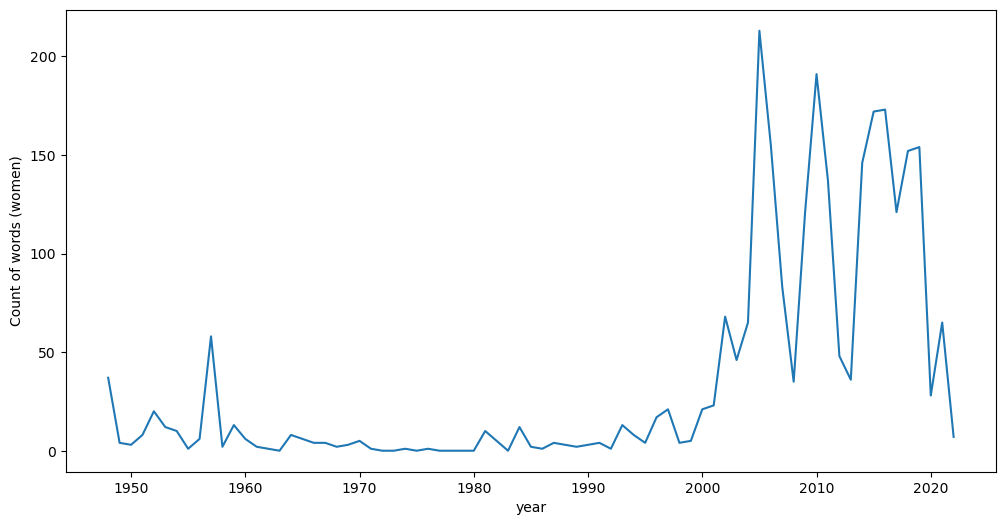

In [194]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.lineplot(x="year", y="cnt", data=data_year, ax=ax)
ax.set_ylabel('Count of words (women)')
plt.show()

## 1point!


In [195]:
n_count_data = np.array(data_year.shape[0])

In [196]:
with pm.Model() as model1:
    alpha = 1.0/data_year.cnt.mean()  
                                   
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    theta = pm.DiscreteUniform("theta", lower=1, upper=n_count_data-1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(theta > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data_year.cnt)
    trace1 = pm.sample(10000, tune=1000, chains=4, random_seed=1,
                       idata_kwargs = {"log_likelihood": True})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 66 seconds.
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


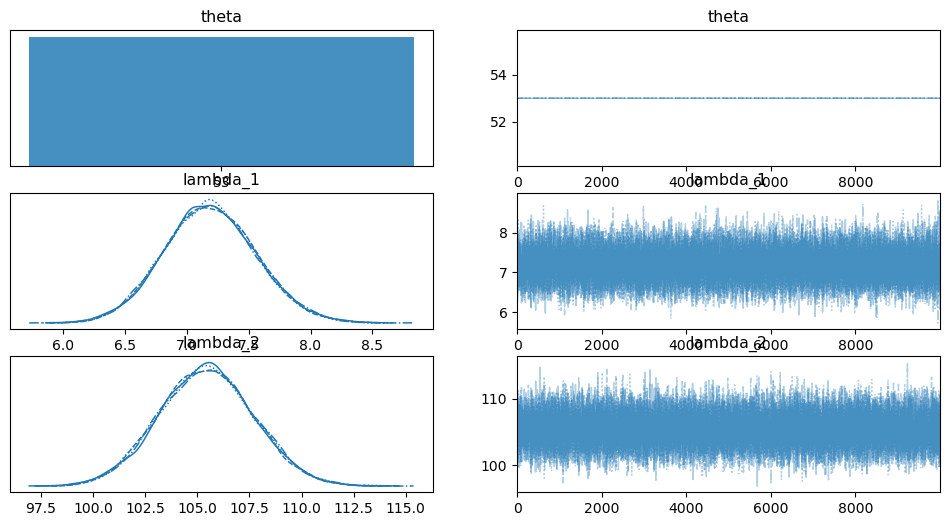

In [197]:
az.plot_trace(trace1)
plt.show()

In [198]:
trace1_sample = az.extract(trace1)

In [199]:
stats.mode(trace1_sample.theta) # index: 53에서 변화가!!!

ModeResult(mode=np.int64(53), count=np.int64(40000))

In [200]:
data_year.iloc[53,:] 

year    2002
cnt       68
Name: 53, dtype: int64

In [201]:
az.summary(trace1)

C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,53.000,0.000,53.000,53.000,0.000,NaN,40000.0,40000.0,NaN
lambda_1,7.190,0.370,6.505,7.894,0.002,0.002,40738.0,29227.0,1.0
lambda_2,105.439,2.252,101.268,109.693,0.012,0.012,37253.0,27585.0,1.0


## 2point!!

In [202]:

with pm.Model() as model2:
    alpha = 1.0/data_year.cnt.mean() 

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
   
    theta_1 = pm.DiscreteUniform("theta_1", lower=0, upper=n_count_data - 2)
    theta_2 = pm.DiscreteUniform("theta_2", lower=theta_1, upper=n_count_data - 1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(theta_2 > idx, 
                             pm.math.switch(theta_1 > idx, 
                                            lambda_1, lambda_2), lambda_3)
    observation = pm.Poisson("obs", lambda_, observed=data_year.cnt)
    trace2 = pm.sample(10000, tune=1000, chains=4, random_seed=1, idata_kwargs = {"log_likelihood": True}, progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2, lambda_3]
>CompoundStep
>>Metropolis: [theta_1]
>>Metropolis: [theta_2]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


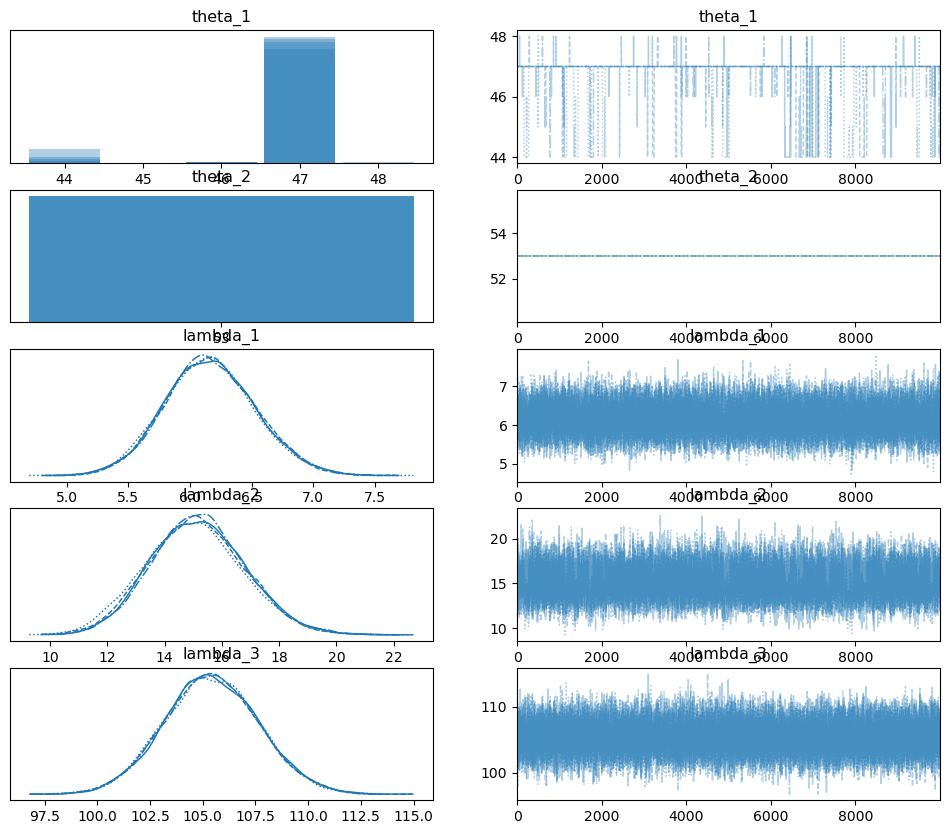

In [203]:
az.plot_trace(trace2)
plt.show()

In [204]:
trace2_sample = az.extract(trace2)

In [205]:
theta1 = stats.mode(trace2_sample.theta_1)
theta2 = stats.mode(trace2_sample.theta_2)

In [206]:
theta1, theta2

(ModeResult(mode=np.int64(47), count=np.int64(37527)),
 ModeResult(mode=np.int64(53), count=np.int64(40000)))

In [207]:
data_year.iloc[[theta1[0], theta2[0]],:] 

,year,cnt
47,1996,17
53,2002,68


In [229]:
az.summary(trace2)

C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_1,46.842,0.665,46.000,47.000,0.037,0.074,373.0,316.0,1.02
theta_2,53.000,0.000,53.000,53.000,0.000,NaN,40000.0,40000.0,NaN
lambda_1,6.161,0.367,5.472,6.852,0.002,0.002,49498.0,29689.0,1.00
lambda_2,15.132,1.666,12.000,18.249,0.027,0.013,3578.0,3737.0,1.00
lambda_3,105.414,2.230,101.131,109.529,0.009,0.011,58830.0,32445.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

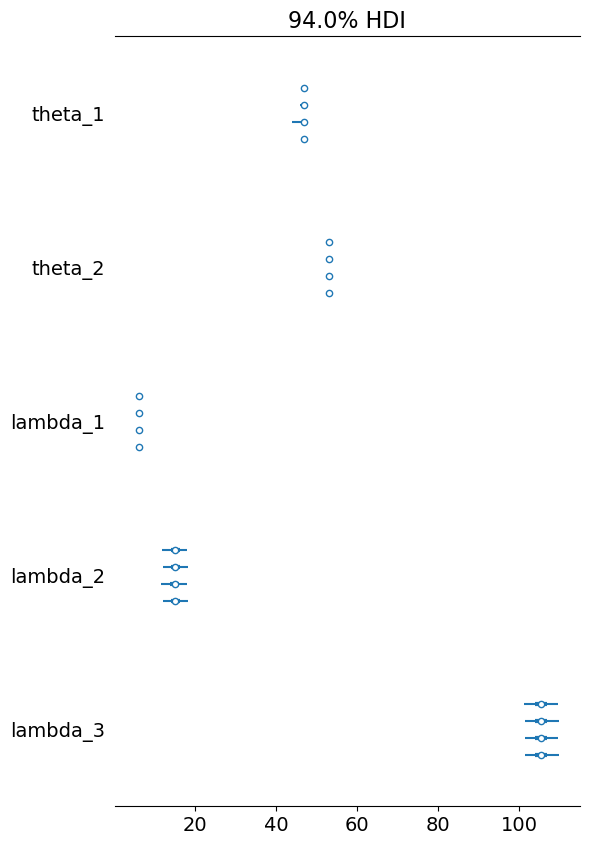

In [208]:
az.plot_forest(trace2)

In [209]:
az.summary(trace2)

C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_1,46.842,0.665,46.000,47.000,0.037,0.074,373.0,316.0,1.02
theta_2,53.000,0.000,53.000,53.000,0.000,NaN,40000.0,40000.0,NaN
lambda_1,6.161,0.367,5.472,6.852,0.002,0.002,49498.0,29689.0,1.00
lambda_2,15.132,1.666,12.000,18.249,0.027,0.013,3578.0,3737.0,1.00
lambda_3,105.414,2.230,101.131,109.529,0.009,0.011,58830.0,32445.0,1.00


## model comparison

In [210]:
result = az.compare({"model1": trace1, "model2":trace2}) # 무엇을 최종적으로 채택해야하는지 결정해주는거래

C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is

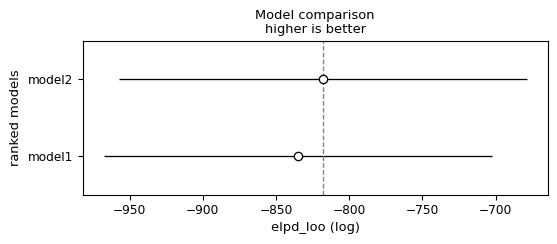

In [211]:
az.plot_compare(result)
plt.show()

In [212]:
# 교수님은 model1이 좋아서 model1로 했지만 난 2가 좋아서 새롭게 함 만들어보자

In [213]:
# 평균 추정치 (lambda 3개)
lambda_1 = trace2_sample.lambda_1.mean()
lambda_2 = trace2_sample.lambda_2.mean()
lambda_3 = trace2_sample.lambda_3.mean()

In [214]:
# 변화점 위치 추정 (최빈값 기준)
theta_1 = stats.mode(trace2_sample.theta_1, keepdims=True)[0][0]
theta_2 = stats.mode(trace2_sample.theta_2, keepdims=True)[0][0]

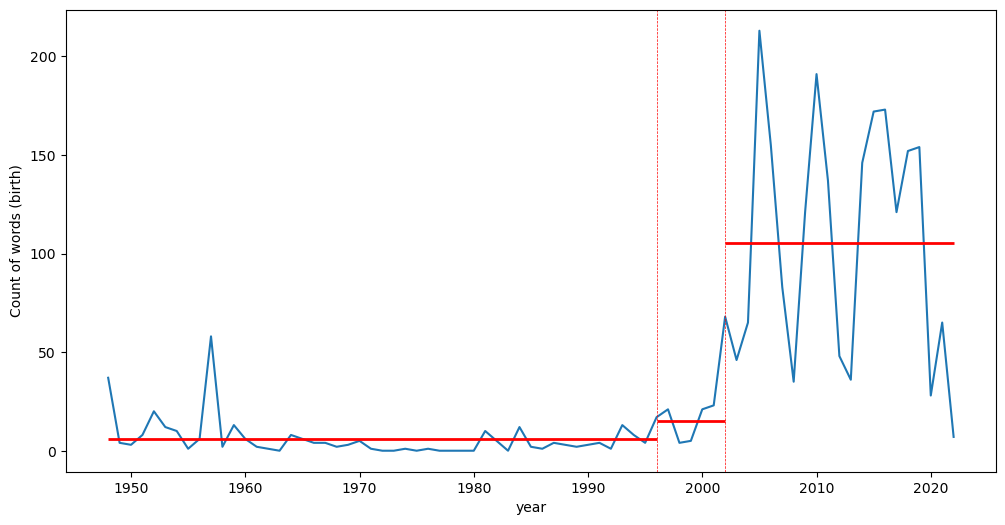

In [215]:
# 시각화
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.lineplot(x="year", y="cnt", data=data_year, ax=ax)
ax.set_ylabel('Count of words (birth)')

# 변화점 위치 표시 (수직선)
plt.axvline(x=data_year.iloc[theta_1]["year"], color='r', ls='--', lw=0.5)
plt.axvline(x=data_year.iloc[theta_2]["year"], color='r', ls='--', lw=0.5)

# 각 구간별 수평선 표시
plt.hlines(y=lambda_1, xmin=data_year.year.iloc[0], xmax=data_year.iloc[theta_1]["year"], 
           colors='red', linewidth=2)
plt.hlines(y=lambda_2, xmin=data_year.iloc[theta_1]["year"], xmax=data_year.iloc[theta_2]["year"], 
           colors='red', linewidth=2)
plt.hlines(y=lambda_3, xmin=data_year.iloc[theta_2]["year"], xmax=data_year.year.iloc[-1], 
           colors='red', linewidth=2)

plt.show()

## 데이터를 반영하지 않은 객관적인 사전확률 분포를 사용해보자

In [216]:
# 데이터는 많기에 나는 객관적인 사전분포를 사용할 것이다
with pm.Model() as model3:
    
    lambda_1 = pm.Gamma("lambda_1", alpha=1, beta=1)
    lambda_2 = pm.Gamma("lambda_2", alpha=1, beta=1)
    
    theta = pm.DiscreteUniform("theta", lower=1, upper=n_count_data-1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(theta > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data_year.cnt)
    trace3 = pm.sample(10000, tune=1000, chains=4, random_seed=1,
                       idata_kwargs = {"log_likelihood": True})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


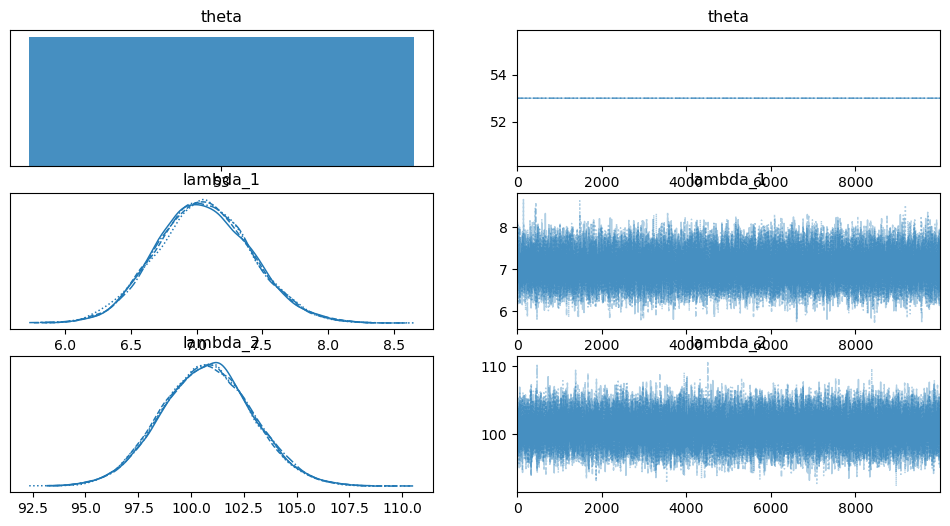

In [217]:
az.plot_trace(trace3)
plt.show()

In [218]:
trace3_sample = az.extract(trace3)

In [219]:
stats.mode(trace3_sample.theta)

ModeResult(mode=np.int64(53), count=np.int64(40000))

In [220]:
data_year.iloc[53,:]

year    2002
cnt       68
Name: 53, dtype: int64

## 객관적 사확분 투포인트!

In [221]:
with pm.Model() as model4:
    
    lambda_1 = pm.Gamma("lambda_1", alpha=1, beta=1)
    lambda_2 = pm.Gamma("lambda_2", alpha=1, beta=1)
    lambda_3 = pm.Gamma("lambda_3", alpha=1, beta=1)
   
    theta_1 = pm.DiscreteUniform("theta_1", lower=0, upper=n_count_data - 2)
    theta_2 = pm.DiscreteUniform("theta_2", lower=theta_1, upper=n_count_data - 1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(theta_2 > idx, 
                             pm.math.switch(theta_1 > idx, 
                                            lambda_1, lambda_2), lambda_3)
    observation = pm.Poisson("obs", lambda_, observed=data_year.cnt)
    trace4 = pm.sample(10000, tune=1000, chains=4, random_seed=1, idata_kwargs = {"log_likelihood": True}, progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2, lambda_3]
>CompoundStep
>>Metropolis: [theta_1]
>>Metropolis: [theta_2]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


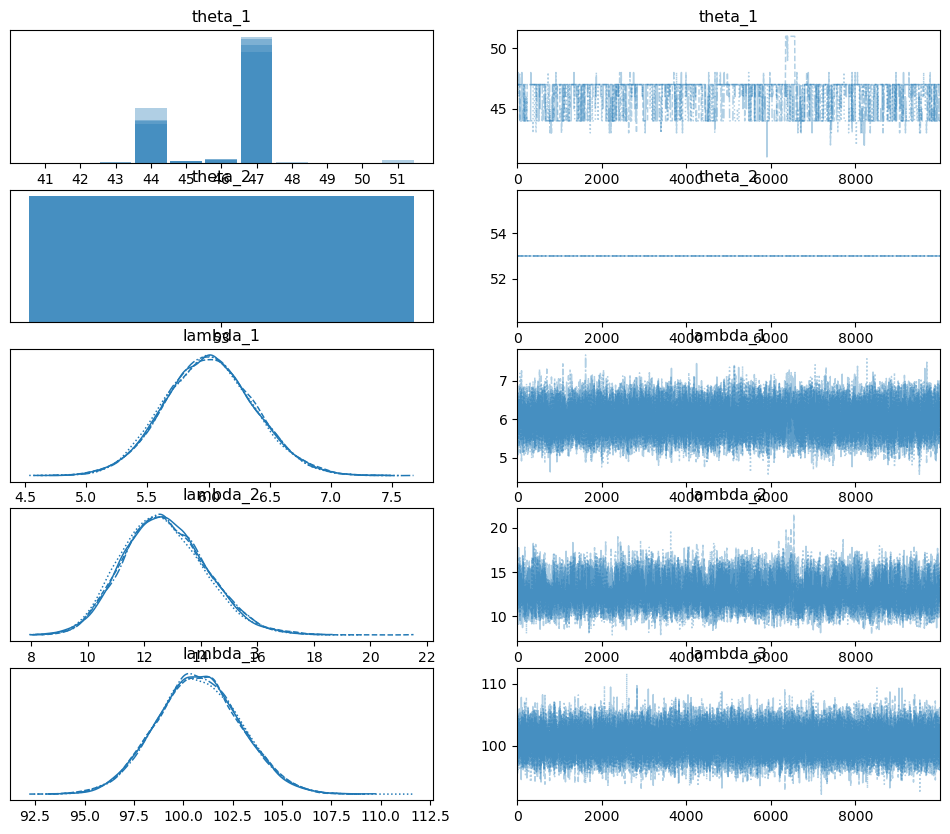

In [182]:
az.plot_trace(trace4)
plt.show()

In [222]:
trace4_sample = az.extract(trace4)

In [223]:
theta1 = stats.mode(trace4_sample.theta_1)
theta2 = stats.mode(trace4_sample.theta_2)

In [224]:
theta1, theta2

(ModeResult(mode=np.int64(47), count=np.int64(27829)),
 ModeResult(mode=np.int64(53), count=np.int64(40000)))

In [225]:
data_year.iloc[[theta1[0], theta2[0]],:] 

,year,cnt
47,1996,17
53,2002,68


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

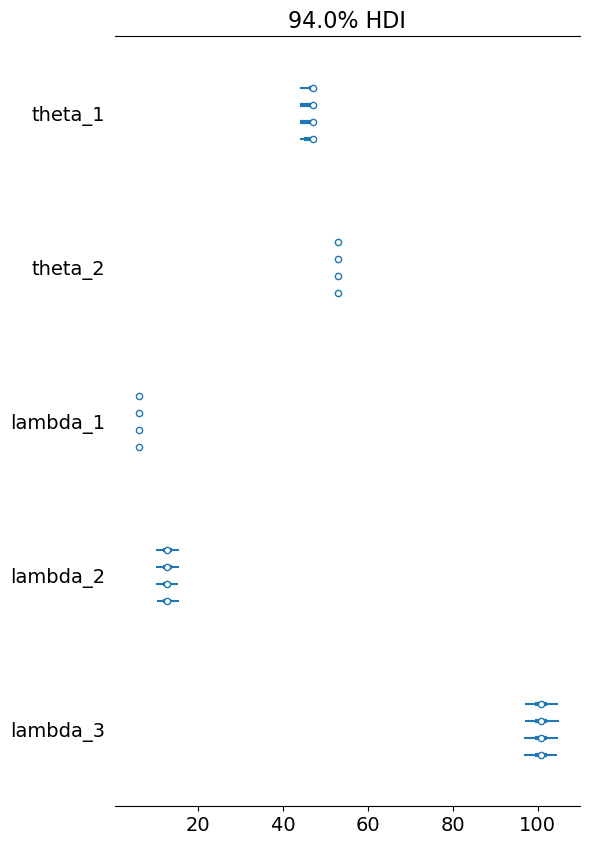

In [226]:
az.plot_forest(trace4)

C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\yeonl\anaconda3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is

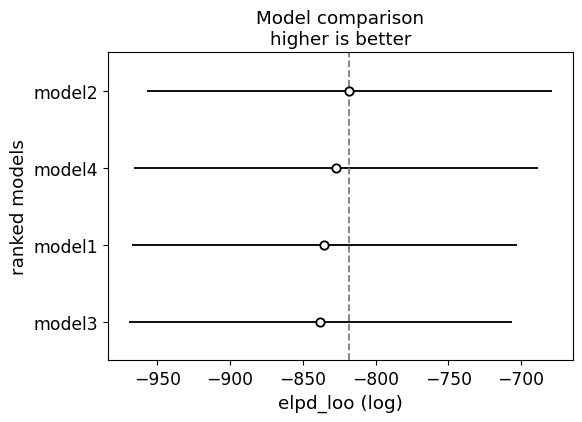

In [227]:
# 이건 4개의 모델을 비교
result = az.compare({
    "model1": trace1,
    "model2": trace2,
    "model3": trace3,
    "model4": trace4,
})
az.plot_compare(result)
plt.show()